## Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
!nvidia-smi

Thu Mar  4 04:08:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    70W / 149W |      0MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [87]:
!pip install opencv-python

    100% |████████████████████████████████| 88.3MB 486kB/s eta 0:00:01    46% |███████████████                 | 41.1MB 47.4MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Stored in directory: /root/.cache/pip/wheels/08/40/b7/fb2e8392888c91eb048b26ea0baa9aae808d056e3786204d0b
Successfully built opencv-python


In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.models import load_model
#write your model here

In [21]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 10#experiment with the batch size

# Visualize Dataset

In [5]:
# lets check some stats
print("Number of Train Videos",len(train_doc))
print("Number of Test Videos",len(val_doc))

Number of Train Videos 663
Number of Test Videos 100


In [17]:
# Get some random folder containing sequences of images
video_folder = train_doc[np.random.randint(0,len(train_doc))].split(";")
video_folder

['WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new',
 'Left Swipe_new_Left Swipe_new',
 '0\n']

In [18]:
# Define Paths
train_path_first = os.path.join('Project_data/train', video_folder[0], '*')
first_images = glob.glob(train_path_first)
first_images[0]

'Project_data/train/WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_38_17_Pro_00073.png'

Shape of image (360, 360, 3)


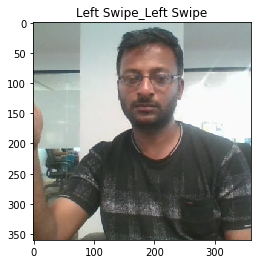

In [19]:
# Pick up some random image from the folder
doc = first_images[np.random.randint(0,len(first_images))]
image = imread(doc)
print("Shape of image",image.shape)
plt.imshow(image)
plt.title(video_folder[1].replace("_new",""))
plt.show()

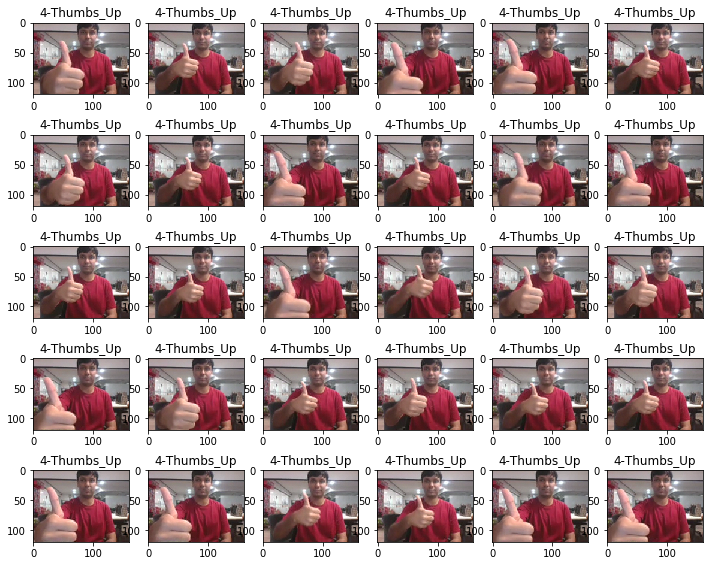

In [9]:
# Plot all images in video folder
plt.figure(figsize=(12,12))
for ind,doc in enumerate(first_images):
    plt.subplot(6,6,ind+1)
    image = imread(doc)
    plt.imshow(image)
    plt.title(video_folder[2].replace("\n","")+"-"+video_folder[1].replace("_new",""))
plt.show()

In [14]:
def center_crop(img, dim):
    """Returns center cropped image

    Args:Image Scaling
    img: image to be center cropped
    dim: dimensions (width, height) to be cropped from center
    """
    width, height = img.shape[1], img.shape[0]
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img
# Crop image using opencv
def crop_img(img):
    shifted = cv2.warpAffine(img, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (img.shape[1], img.shape[0]))

    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

    x0, y0 = np.argwhere(gray > 0).min(axis=0)
    x1, y1 = np.argwhere(gray > 0).max(axis=0) 

    cropped=shifted[x0:x1,y0:y1,:]
    return cropped

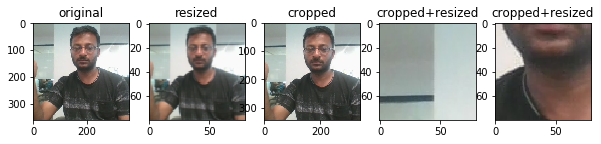

In [20]:
# Lets try different image manipulation techniques
image_size = 80
#cimage = crop(image, ((10, 30), (20, 20), (0,0)), copy=False)
#  coordinates for the box are (left, upper, right, lower)
box = (10, 20, 130, 100)
cimage = Image.fromarray(image).crop(box)
crop_image = center_crop(image,(80,80))
rimage = imresize(image,(image_size,image_size,3))
rcimage = imresize(cimage,(image_size,image_size,3))
f, axes = plt.subplots(1, 5)
f.set_figwidth(10)
axes[0].imshow(image)
axes[0].set_title("original")
axes[1].imshow(rimage)
axes[1].set_title("resized")
axes[2].imshow(crop_img(image))
axes[2].set_title("cropped")
axes[3].imshow(rcimage)
axes[3].set_title("cropped+resized")
axes[4].imshow(crop_image)
axes[4].set_title("cropped+resized")
plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
total_frames = 30
def generator(source_path, folder_list, batch_size, sample_frames=10, image_size = 80):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    print( 'sample_frames = ', sample_frames, '; image_size =', image_size)
    img_idx = np.round(np.linspace(0,total_frames-1,sample_frames)).astype(int)#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx) # time dimension
            y=image_size # height
            z=image_size # width
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    rimage = imresize(image,(image_size,image_size,3))
                    
                    batch_data[folder,idx,:,:,0] = (rimage[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (rimage[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (rimage[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        #remaining_seq=len(t)%batch_size
        if (len(source_path)%batch_size)//2==0:
            batch_size = 2
            num_batches = len(source_path)%batch_size
        else:
            batch_size = 1
            num_batches = len(source_path)
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx) # time dimension
            y=image_size # height
            z=image_size # width
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    rimage = imresize(image,(image_size,image_size,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    # Cropping ?? Question
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (rimage[:,:,0])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (rimage[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (rimage[:,:,2])/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model
### CNN 3D
Lets design NN Model Architecture with 4 layers of Conv3D and Max Polling layer. Then conclude with two Dense Layers

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
# Define filter and pool size
filtersize=(3,3,3)
pool_size=(2, 2, 2)
image_size = 100
model_conv3d1 = Sequential([
                     Conv3D(16, filtersize, padding='same', activation='relu',input_shape=(batch_size, image_size, image_size, 3)),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=pool_size, padding='same'),

                     Conv3D(32, filtersize, padding='same', activation='relu'),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=pool_size, padding='same'),

                     Conv3D(64, filtersize, padding='same', activation='relu'),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=pool_size, padding='same'),

                     Conv3D(128, filtersize, padding='same', activation='relu'),
                     BatchNormalization(),
                     MaxPooling3D(pool_size=pool_size, padding='same'),

                     Flatten(),
                     Dense(128, activation='relu'),
                     BatchNormalization(),
                     Dropout(0.5),

                     Flatten(),
                     Dense(64, activation='relu'),
                     BatchNormalization(),
                     Dropout(0.25),

                     Dense(5, activation='softmax')
])

optimiser = 'adam'#write your optimizer
model_conv3d1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 10, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 50, 50, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 50, 50, 32)     13856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 50, 50, 32)     128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 3, 25, 25, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 3, 25, 25, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
def initialise_model_parms():
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]
    return callbacks_list

In [14]:
batch_size = 15
callbacks = initialise_model_parms()
train_generator = generator(train_path, train_doc, batch_size, sample_frames=10, image_size=100)
val_generator = generator(val_path, val_doc, batch_size, sample_frames=10, image_size=100)

W0304 10:10:10.155058 140618743359296 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
model_conv3d1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 15
Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.7202 - categorical_accuracy: 0.3949Source path =  Project_data/val ; batch size = 15

Epoch 00001: saving model to model_init_2021-03-0410_06_46.605389/model-00001-1.72024-0.39486-2.54706-0.18478.h5
45/45 [==============================] - 97s 2s/step - loss: 1.7202 - categorical_accuracy: 0.3949 - val_loss: 2.5471 - val_categorical_accuracy: 0.1848 - lr: 0.0010
Epoch 2/15
44/45 [============================>.] - ETA: 0s - loss: 1.6177 - categorical_accuracy: 0.2045
Epoch 00002: saving model to model_init_2021-03-0410_06_46.605389/model-00002-1.61671-0.20000-11.04322-0.14286.h5
45/45 [==============================] - 3s 70ms/step - loss: 1.6167 - categorical_accuracy: 0.2000 - val_loss: 11.0432 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 1.6052 - categorical_accuracy: 0.2889
Epoch 00003: saving

### Conclusion
- we see that model is underfitting with accuracy of 0.11 and validation accuracy of 0.28

# LSTM + CNN
### LSTM 1st Model

In [50]:
# Define a common class to initial steps before model creation
class rnn_cnn_model:
    
    def __init__(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        self.batch_size = batch_s
        self.image_size = image_s
        self.sample_frames = sample_n
        self.num_epochs = epochs_n
        self.train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
        self.val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
        self.num_train_sequences = len(self.train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        print('# validation sequences =', self.num_val_sequences)
        print ('# epochs =', self.num_epochs)
        self.total_frames=30
        self.num_classes=5
        curr_dt_time = datetime.datetime.now()
        self.train_path = 'Project_data/train'
        self.val_path = 'Project_data/val'
        self.channels=3
        self.dropout = dropout
        self.dense_n = dense_n
        self.lstm_cells = lstm_cells
        self.optimiser = optimiser
        
        if (self.num_train_sequences%self.batch_size) == 0:
            self.steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            self.steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            self.validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            self.validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
    def generator(self,source_path, folder_list):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.sample_frames)).astype(int)

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//self.batch_size

            for batch in range(num_batches): 
                batch_data, batch_labels= self.get_data(source_path,t,batch,self.batch_size,img_idx)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%self.batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.get_data(source_path,t,num_batches,self.batch_size,img_idx,remaining_seq)
                yield batch_data, batch_labels 


    def get_data(self,source_path,t,batch,batch_size,img_idx,remaining_seq=0):
        
        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_size,self.image_size,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 



        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_size,self.image_size,3))

                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        return(batch_data,batch_labels)
    
    # asbtract method
    def create_model(self):
        pass
    
    def train_model(self):
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
        #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]
        # generator(self,source_path, folder_list)
        train_generator = self.generator(self.train_path, self.train_doc)
        val_generator = self.generator(self.val_path, self.val_doc)

        self.history = self.model.fit(train_generator, steps_per_epoch=self.steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=self.validation_steps, class_weight=None, workers=1, initial_epoch=0)  
        
    def plot_accuracy(self):
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.num_epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
    

In [6]:
# Define 
class lstm_1(rnn_cnn_model):
    def create_model(self):
            self.model= Sequential([

                TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(self.sample_frames,self.image_size,self.image_size,self.channels)),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Flatten()),
                LSTM(self.lstm_cells),
                Dropout(self.dropout),

                Dense(self.dense_n,activation='relu'),
                Dropout(self.dropout),

                Dense(self.num_classes, activation='softmax')

            ])
            self.optimiser = optimizers.Adam()
            self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            print(self.model.summary())

In [57]:
# HYperparameters
# batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'
rnn_trainer = lstm_1(batch_s=8,image_s=120,epochs_n=20,sample_n=18)
rnn_trainer.create_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_148 (TimeDi (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_149 (TimeDi (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_150 (TimeDi (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_151 (TimeDi (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_152 (TimeDi (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_153 (TimeDi (None, 18, 30, 30, 32)    0         
__________________________________________________

In [53]:
# train the model
rnn_trainer.train_model()

W0306 07:46:14.583705 140044132341568 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.5399 - categorical_accuracy: 0.2974
Epoch 00001: saving model to model_init_2021-03-0607_46_14.583473/model-00001-1.53990-0.29742-1.61808-0.24038.h5
83/83 [==============================] - 128s 2s/step - loss: 1.5399 - categorical_accuracy: 0.2974 - val_loss: 1.6181 - val_categorical_accuracy: 0.2404 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.3892 - categorical_accuracy: 0.3672
Epoch 00002: saving model to model_init_2021-03-0607_46_14.583473/model-00002-1.38919-0.36722-1.69732-0.25962.h5
83/83 [==============================] - 68s 818ms/step - loss: 1.3892 - categorical_accuracy: 0.3672 - val_loss: 1.6973 - val_categorical_accuracy: 0.2596 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.3086 - categorical_accuracy: 0.4067
Epoch 00003: saving model to model_init_2021-03-0607_46_14.583473/model-00003-1.30860-0.40668-1.76521-0.29808.h5
83/83 [

In [ ]:
# Plot accuracy
rnn_trainer.plot_accuracy()

### Conclusion
- Hyperparameters choosen were batch_s=8,image_s=120,epochs_n=20,sample_n=18
- We see that model is neither too much underfitting as before nor overfitting as the both training and validation accuracy is almost same, 

## LSTM 2nd Model
### GRU Model 

In [52]:
# Define GRU Model
class gru_1(rnn_cnn_model):
    def __init(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        super().__init__(batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam')
        
    def create_model(self):
        
            print("Creating GRU Model")
            self.model= Sequential([

                TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(self.sample_frames,self.image_size,self.image_size,self.channels)),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),
                

                TimeDistributed(Flatten()),
                GRU(self.lstm_cells),
                Dropout(self.dropout),

                Dense(self.dense_n,activation='relu'),
                Dropout(self.dropout),

                Dense(self.num_classes, activation='softmax')

            ])
            self.optimiser = optimizers.Adam()
            self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            print(self.model.summary())

In [25]:
gru_trainer = gru_1(batch_s=15,image_s=100,epochs_n=20,sample_n=18)
gru_trainer.create_model()
gru_trainer.train_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
Creating GRU Model


W0306 17:39:25.082404 139904513865536 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_41 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 18, 25, 25, 64)   

Epoch 15/20
44/45 [============================>.] - ETA: 0s - loss: 0.4789 - categorical_accuracy: 0.8318
Epoch 00015: saving model to model_init_2021-03-0617_39_25.081972/model-00015-0.47708-0.83258-0.86424-0.66000.h5
45/45 [==============================] - 53s 1s/step - loss: 0.4771 - categorical_accuracy: 0.8326 - val_loss: 0.8642 - val_categorical_accuracy: 0.6600 - lr: 4.0000e-05
Epoch 16/20
44/45 [============================>.] - ETA: 1s - loss: 0.4368 - categorical_accuracy: 0.8591
Epoch 00016: saving model to model_init_2021-03-0617_39_25.081972/model-00016-0.43568-0.85973-0.82401-0.70000.h5
45/45 [==============================] - 54s 1s/step - loss: 0.4357 - categorical_accuracy: 0.8597 - val_loss: 0.8240 - val_categorical_accuracy: 0.7000 - lr: 4.0000e-05
Epoch 17/20
45/45 [==============================] - ETA: 0s - loss: 0.4245 - categorical_accuracy: 0.8688
Epoch 00017: saving model to model_init_2021-03-0617_39_25.081972/model-00017-0.42454-0.86878-0.74632-0.76000.h5


In [ ]:
gru_trainer.plot_accuracy()

### Conclusion 
- We see that accuracy improved after changing it to GRU Model to training accurayc of 87% and validation accuracy of 81%. 
- We see that there is slight overfitting still

## LSTM 3rd Model
### GRU Model 2
- Model with more number of samples

In [53]:
gru_trainer_2 = gru_1(batch_s=8,image_s=120,epochs_n=20,sample_n=25)
gru_trainer_2.create_model()
gru_trainer_2.train_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
Creating GRU Model


W0308 07:06:10.162121 139930383234880 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 25, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 25, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 25, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 25, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 25, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 25, 30, 30, 64)   

Epoch 16/20
83/83 [==============================] - ETA: 0s - loss: 0.8276 - categorical_accuracy: 0.6682
Epoch 00016: val_loss improved from 1.02444 to 0.84431, saving model to model_init_2021-03-0807_06_10.158767/model-00016-0.82755-0.66817-0.84431-0.66000.h5
83/83 [==============================] - 74s 897ms/step - loss: 0.8276 - categorical_accuracy: 0.6682 - val_loss: 0.8443 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 17/20
83/83 [==============================] - ETA: 0s - loss: 0.8318 - categorical_accuracy: 0.6712
Epoch 00017: val_loss did not improve from 0.84431
83/83 [==============================] - 76s 919ms/step - loss: 0.8318 - categorical_accuracy: 0.6712 - val_loss: 1.0366 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 18/20
83/83 [==============================] - ETA: 0s - loss: 0.8160 - categorical_accuracy: 0.6968
Epoch 00018: val_loss did not improve from 0.84431
83/83 [==============================] - 76s 911ms/step - loss: 0.8160 - categorica

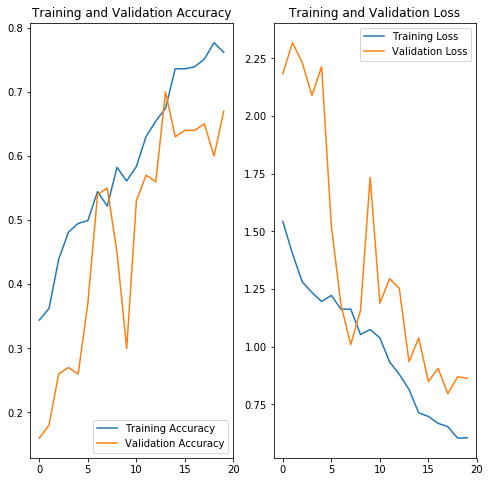

In [44]:
gru_trainer_2.plot_accuracy()

### COnclusion
- We see that validation accuracy reduced with number of samples

## LSTM 4th Model
### GRU Model 3
- Model with lesser layers
- No augmentation

In [54]:
class gru_2(rnn_cnn_model):
    def __init(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        super().__init__(batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam')
        
    def create_model(self):
        
            print("Creating GRU Model")
            self.model= Sequential([

                TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(self.sample_frames,self.image_size,self.image_size,self.channels)),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),
                Dropout(self.dropout),

                TimeDistributed(Flatten()),
                GRU(self.lstm_cells),
                Dropout(self.dropout),

                Dense(self.dense_n,activation='relu'),
                Dropout(self.dropout),

                Dense(self.num_classes, activation='softmax')

            ])
            self.optimiser = optimizers.Adam()
            self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            print(self.model.summary())

In [55]:
gru_trainer_3 = gru_2(batch_s=15,image_s=120,epochs_n=20,sample_n=25,dropout=0.25,dense_n=128,lstm_cells=128)
gru_trainer_3.create_model()
gru_trainer_3.train_model()

# training sequences = 663
# validation sequences = 100
# epochs = 20
Creating GRU Model


W0308 07:32:09.053398 139930383234880 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 25, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 25, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 25, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 25, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 25, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 25, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 25, 30, 30, 64)   

Epoch 16/20
45/45 [==============================] - ETA: 0s - loss: 0.3683 - categorical_accuracy: 0.8778
Epoch 00016: val_loss improved from 0.76306 to 0.67575, saving model to model_init_2021-03-0807_32_09.052409/model-00016-0.36830-0.87783-0.67575-0.75000.h5
45/45 [==============================] - 77s 2s/step - loss: 0.3683 - categorical_accuracy: 0.8778 - val_loss: 0.6757 - val_categorical_accuracy: 0.7500 - lr: 4.0000e-05
Epoch 17/20
45/45 [==============================] - ETA: 0s - loss: 0.3207 - categorical_accuracy: 0.9035
Epoch 00017: val_loss did not improve from 0.67575
45/45 [==============================] - 76s 2s/step - loss: 0.3207 - categorical_accuracy: 0.9035 - val_loss: 0.6953 - val_categorical_accuracy: 0.7200 - lr: 4.0000e-05
Epoch 18/20
45/45 [==============================] - ETA: 0s - loss: 0.3078 - categorical_accuracy: 0.9110
Epoch 00018: val_loss did not improve from 0.67575
45/45 [==============================] - 76s 2s/step - loss: 0.3078 - categorical

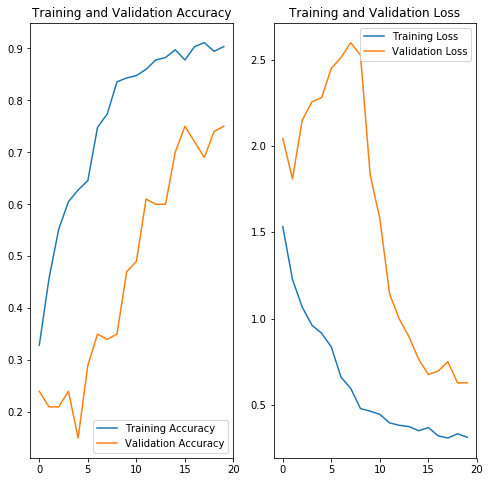

In [ ]:
gru_trainer_3.plot_accuracy()

### Conclusion 
- We see that overfitting reduced a little bit , but the overall accuracy also reduced 

## LSTM 5th Model
### GRU Model 4
- Adding augmentation which will rotate the image and also crop , 

In [4]:
class rnn_cnn_model_2:
    
    def __init__(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        print("Different technique of Normalization + cropping")
        self.batch_size = batch_s
        self.image_size = image_s
        self.sample_frames = sample_n
        self.num_epochs = epochs_n
        self.train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
        self.val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
        self.num_train_sequences = len(self.train_doc)
        print('# training sequences =', self.num_train_sequences)
        self.num_val_sequences = len(self.val_doc)
        print('# validation sequences =', self.num_val_sequences)
        print ('# epochs =', self.num_epochs)
        self.total_frames=30
        self.num_classes=5
        curr_dt_time = datetime.datetime.now()
        self.train_path = 'Project_data/train'
        self.val_path = 'Project_data/val'
        self.channels=3
        self.dropout = dropout
        self.dense_n = dense_n
        self.lstm_cells = lstm_cells
        self.optimiser = optimiser
        
        if (self.num_train_sequences%self.batch_size) == 0:
            self.steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            self.steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            self.validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            self.validation_steps = (self.num_val_sequences//self.batch_size) + 1
        
    def generator(self,source_path, folder_list):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.sample_frames)).astype(int)

        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//self.batch_size

            for batch in range(num_batches): 
                batch_data, batch_labels= self.get_data(source_path,t,batch,self.batch_size,img_idx)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%self.batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.get_data(source_path,t,num_batches,self.batch_size,img_idx,remaining_seq)
                yield batch_data, batch_labels 


    def get_data(self,source_path,t,batch,batch_size,img_idx,remaining_seq=0):
        
        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_size,self.image_size,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
        batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_size,self.image_size,self.channels))


        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_size,self.image_size,3))
                #normalizing the images
                batch_data[folder,idx,:,:,0] = self.normalize_image1(image_resized[:,:,0])
                batch_data[folder,idx,:,:,1] = self.normalize_image1(image_resized[:,:,1])
                batch_data[folder,idx,:,:,2] = self.normalize_image1(image_resized[:,:,2])
                
                rotated = self.augment_data(image_resized)
                
                batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        batch_data=np.concatenate([batch_data,batch_data_aug])
        batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
    
    def augment_data(self,img):
        shifted = cv2.warpAffine(img, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                 (img.shape[1], img.shape[0]))
                    
        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

        x0, y0 = np.argwhere(gray > 0).min(axis=0)
        x1, y1 = np.argwhere(gray > 0).max(axis=0) 

        cropped=shifted[x0:x1,y0:y1,:]

        image_resized=imresize(cropped,(self.image_size,self.image_size,3))

        M = cv2.getRotationMatrix2D((self.image_size//2,self.image_size//2),
                                    np.random.randint(-10,10), 1.0)
        rotated = cv2.warpAffine(image_resized, M, (self.image_size, self.image_size))

        return rotated
    #using percentile to deal with outliers in the data.
    def normalize_image(self,img):
        normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
        return normalized_image
    #normalise image
    def normalize_image1(self,img):
        normalized_image= img/255
        return normalized_image
    
    #data cropping
    def crop_img(self,img):
        if img.shape[0] != img.shape[1]:
            img=img[0:120,10:150]
        
        return img
    def crop_img2(self,img):
        shifted = cv2.warpAffine(img, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (img.shape[1], img.shape[0]))

        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

        x0, y0 = np.argwhere(gray > 0).min(axis=0)
        x1, y1 = np.argwhere(gray > 0).max(axis=0) 

        cropped=shifted[x0:x1,y0:y1,:]
        return cropped
    # asbtract method
    def create_model(self):
        pass
    
    def train_model(self):
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
        #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]
        # generator(self,source_path, folder_list)
        train_generator = self.generator(self.train_path, self.train_doc)
        val_generator = self.generator(self.val_path, self.val_doc)

        self.history = self.model.fit(train_generator, steps_per_epoch=self.steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=self.validation_steps, class_weight=None, workers=1, initial_epoch=0)  
        
    def plot_accuracy(self):
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.num_epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
    

In [5]:
class gru_3(rnn_cnn_model_2):
    def __init(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        super().__init__(batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam')
        
    def create_model(self):
        
            print("Creating GRU Model")
            self.model= Sequential([

                TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(self.sample_frames,self.image_size,self.image_size,self.channels)),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),
                
                TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Flatten()),
                GRU(self.lstm_cells),
                Dropout(self.dropout),

                Dense(self.dense_n,activation='relu'),
                Dropout(self.dropout),

                Dense(self.num_classes, activation='softmax')

            ])
            self.optimiser = optimizers.Adam(lr=0.0002)
            self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            print(self.model.summary())

In [6]:
gru_trainer_4 = gru_3(batch_s=5,image_s=120,epochs_n=20,sample_n=18,dropout=0.25,dense_n=128,lstm_cells=128)
gru_trainer_4.create_model()
gru_trainer_4.train_model()

Different technique of Normalization + cropping
# training sequences = 663
# validation sequences = 100
# epochs = 20
Creating GRU Model


W0308 08:27:25.559767 140503522252608 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)    1

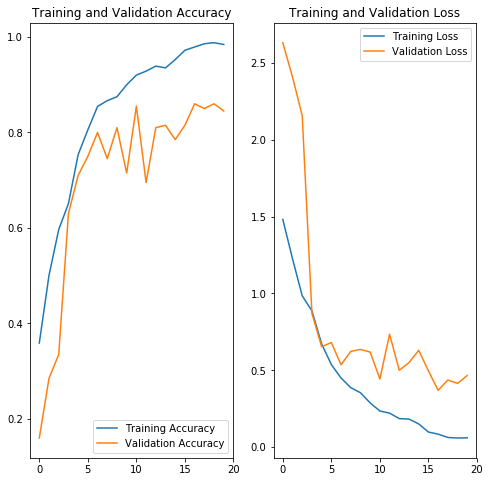

In [7]:
gru_trainer_4.plot_accuracy()

### Conclusion 
- We see that model is overfitting a lot with more augmentaion, but accuracy has improved a lot 
- But so far this is the best model with high validation accuracy

## LSTM 6th Model 
### LSTM Model with augmentation

In [16]:
class lstm_augm(rnn_cnn_model_2):
    def __init(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        super().__init__(batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam')
        
    def create_model(self):
        
            print("Creating LSTM Model")
            self.model= Sequential([

                TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                      input_shape=(self.sample_frames,self.image_size,self.image_size,self.channels)),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),
                
                TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Flatten()),
                LSTM(self.lstm_cells),
                Dropout(self.dropout),

                Dense(self.dense_n,activation='relu'),
                Dropout(self.dropout),

                Dense(self.num_classes, activation='softmax')

            ])
            self.optimiser = optimizers.Adam(lr=0.0002)
            self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            print(self.model.summary())

In [17]:
lstm_trainer_4 = lstm_augm(batch_s=20,image_s=120,epochs_n=20,sample_n=18,dropout=0.25,dense_n=128,lstm_cells=128)
lstm_trainer_4.create_model()
lstm_trainer_4.train_model()

Different technique of Normalization + cropping
# training sequences = 663
# validation sequences = 100
# epochs = 20
Creating LSTM Model


W0307 17:32:18.580849 140720081282880 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_14 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 30, 30, 64)   

In [ ]:
lstm_trainer_4.plot_accuracy()

### Conclusion
- We see that the model is overfitting even in LSTM Model also 

## LSTM 7th model - Transfer Learning
### GRU + Transfer Learning (Training all weights)
- Lets train a mobile net model by training all weights using GRU

In [14]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
class gru_4(rnn_cnn_model_2):
    def __init(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        super().__init__(batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam')
        
    def create_model(self):
            print("Creating GRU Model")
            self.model= Sequential([
                                    
                TimeDistributed(mobilenet_transfer,input_shape=(self.sample_frames,self.image_size,self.image_size,self.channels)),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Flatten()),
                GRU(self.lstm_cells),
                Dropout(self.dropout),

                Dense(self.dense_n,activation='relu'),
                Dropout(self.dropout),

                Dense(self.num_classes, activation='softmax')

            ])
            self.optimiser = optimizers.Adam()
            self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            print(self.model.summary())

W0308 09:10:58.329858 140503522252608 mobilenet.py:216] `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


17227776/17225924 [==============================] - 0s 0us/step


In [10]:
gru_trainer_5 = gru_4(batch_s=5,image_s=120,epochs_n=20,sample_n=16)
gru_trainer_5.create_model()
gru_trainer_5.train_model()

Different technique of Normalization + cropping
# training sequences = 663
# validation sequences = 100
# epochs = 20
Creating GRU Model


W0307 16:25:13.056663 140720081282880 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                209280    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [ ]:
gru_trainer_5.plot_accuracy()

### Conclusion 
- We may have got the best model till now with accuracy of 99% and validation accuracy of 95%. We dont see any ovefitting in this

## LSTM 8th Model
### LSTM + Transfer Learning
- TO reduce time, lets not train all weights and also use LSTM instead of GRU

In [13]:
class lstm_tl(rnn_cnn_model_2):
    def __init(self,batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam'):
        super().__init__(batch_s,image_s,epochs_n,sample_n,dropout=0.25,dense_n=64,lstm_cells=64,optimiser='adam')
        
    def create_model(self):
        
            print("Creating LSTM Model")
            self.model= Sequential([
                                    
                TimeDistributed(mobilenet_transfer,input_shape=(self.sample_frames,self.image_size,self.image_size,self.channels)),
                TimeDistributed(BatchNormalization()),
                TimeDistributed(MaxPooling2D((2, 2))),

                TimeDistributed(Flatten()),
                LSTM(self.lstm_cells),
                Dropout(self.dropout),

                Dense(self.dense_n,activation='relu'),
                Dropout(self.dropout),

                Dense(self.num_classes, activation='softmax')

            ])
            self.optimiser = optimizers.Adam()
            self.model.compile(optimizer=self.optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
            print(self.model.summary())
            for layer in self.model.layers:
                layer.trainable = False

In [14]:
gru_trainer_6 = lstm_tl(batch_s=5,image_s=120,epochs_n=20,sample_n=16,dense_n=128,lstm_cells=128)
gru_trainer_6.create_model()
gru_trainer_6.train_model()

Different technique of Normalization + cropping
# training sequences = 663
# validation sequences = 100
# epochs = 20
Creating LSTM Model


W0307 16:57:44.020155 140720081282880 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

Epoch 19/20
133/133 [==============================] - ETA: 0s - loss: 0.0321 - categorical_accuracy: 0.9902
Epoch 00019: val_loss did not improve from 0.16022
133/133 [==============================] - 75s 567ms/step - loss: 0.0321 - categorical_accuracy: 0.9902 - val_loss: 0.3386 - val_categorical_accuracy: 0.9150 - lr: 4.0000e-05
Epoch 20/20
133/133 [==============================] - ETA: 0s - loss: 0.0174 - categorical_accuracy: 0.9940
Epoch 00020: val_loss did not improve from 0.16022
133/133 [==============================] - 76s 571ms/step - loss: 0.0174 - categorical_accuracy: 0.9940 - val_loss: 0.3385 - val_categorical_accuracy: 0.9150 - lr: 4.0000e-05


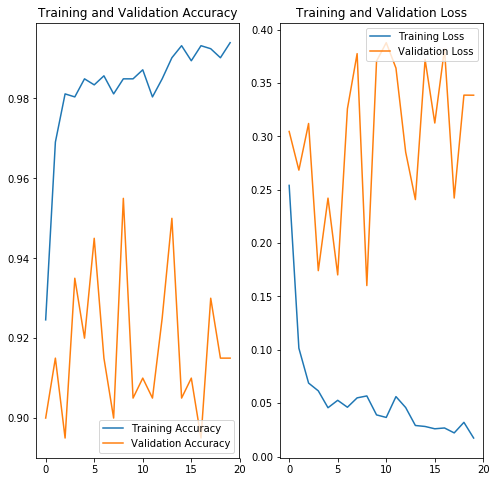

In [15]:
gru_trainer_6.plot_accuracy()

### Conclusion
- We clearly see that by disabling weights, the model turns out be overfitting
- Though we can treat this as our second best model

# CNN 3D
- Lets evaluate model with just CNN 3D as we did in our sample Model

## CNN Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [13]:
import numpy as np

In [14]:
import abc
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_directory):
        self.train_doc = np.random.permutation(open(project_directory + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_directory + '/' + 'val.csv').readlines())
        self.train_path = project_directory + '/' + 'train'
        self.val_path =  project_directory + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [15]:
# plot_result function will be used for training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [16]:
project_directory ='Project_data'
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=32,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_directory)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 50, 50, 32)    1

In [23]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 440581
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.4401 - categorical_accuracy: 0.4449
Epoch 00001: val_loss improved from inf to 1.51050, saving model to model_init_2021-03-0804_34_37.838415/model-00001-1.44005-0.44495-1.51050-0.25000.h5
17/17 [==============================] - 133s 8s/step - loss: 1.4401 - categorical_accuracy: 0.4449 - val_loss: 1.5105 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9145 - categorical_accuracy: 0.6802
Epoch 00002: val_loss did not improve from 1.51050
17/17 [==============================] - 60s 4s/step - loss: 0.9145 - categorical_accuracy: 0.6802 - val_loss: 2.3432 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6496 - categorical_accuracy: 0.7843
Epoch 00003: val_loss did not improve from 1.51050
17/17 [==============================] - 57s 3s/step - loss: 0.6496 - cate

In [ ]:
plot(history_model1)

#### Conclusion
We can see clearly here as model is overfitting

## CNN Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 15

In [18]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_directory)
conv_3d2.initialize_image_properties(image_height=120,image_width=120)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=15)
conv_3d2_model=conv_3d2.define_model(dense_neurons=64,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 10, 60, 60, 32)   

In [19]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 694853
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.5890 - categorical_accuracy: 0.4223
Epoch 00001: val_loss improved from inf to 1.71869, saving model to model_init_2021-03-0717_48_43.017485/model-00001-1.58897-0.42232-1.71869-0.24000.h5
34/34 [==============================] - 122s 4s/step - loss: 1.5890 - categorical_accuracy: 0.4223 - val_loss: 1.7187 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.0997 - categorical_accuracy: 0.5543
Epoch 00002: val_loss did not improve from 1.71869
34/34 [==============================] - 120s 4s/step - loss: 1.0997 - categorical_accuracy: 0.5543 - val_loss: 2.4849 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.9578 - categorical_accuracy: 0.6350
Epoch 00003: val_loss did not improve from 1.71869
34/34 [==============================] - 121s 4s/step - loss: 0.9578 - ca

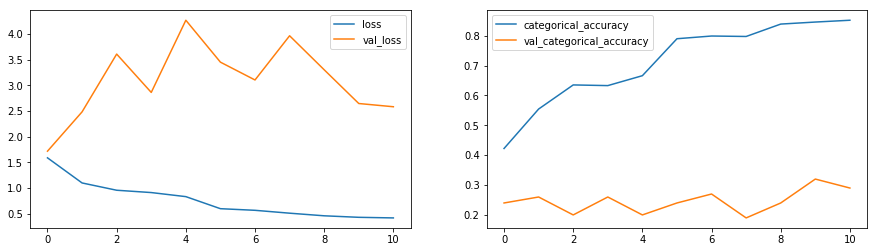

In [21]:
plot(history_model2)

Hence we can see that result didnt improve much.

## CNN Model 3 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 15

In [27]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=32,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_directory)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 8, 60, 60, 16)    

In [29]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 7658869
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 2.0125 - categorical_accuracy: 0.3484
Epoch 00001: val_loss improved from inf to 1.76294, saving model to model_init_2021-03-0718_33_35.061253/model-00001-2.01255-0.34842-1.76294-0.36000.h5
34/34 [==============================] - 105s 3s/step - loss: 2.0125 - categorical_accuracy: 0.3484 - val_loss: 1.7629 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.5555 - categorical_accuracy: 0.4729
Epoch 00002: val_loss did not improve from 1.76294
34/34 [==============================] - 102s 3s/step - loss: 1.5555 - categorical_accuracy: 0.4729 - val_loss: 2.0063 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.3451 - categorical_accuracy: 0.5347
Epoch 00003: val_loss did not improve from 1.76294
34/34 [==============================] - 102s 3s/step - loss: 1.3451 - c

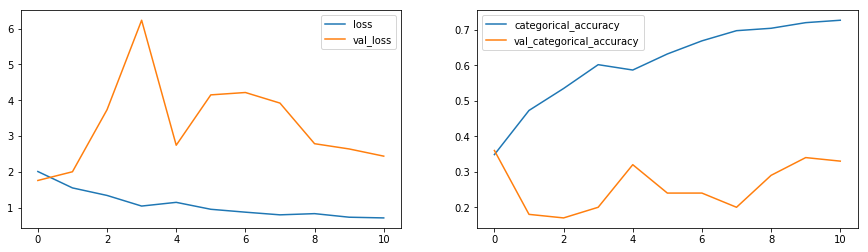

In [31]:
plot(history_model4)

#### Conclusion
With more layers we dont see much performance improvement. We get a best validation accuracy of 34% . Let's try adding dropouts at the convolution layers

## CNN Model 4
### Adding dropout at convolution layers

In [32]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_directory)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_42 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_43 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 8, 60, 60, 16)    

In [35]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7861 - categorical_accuracy: 0.3824
Epoch 00001: val_loss improved from inf to 1.69913, saving model to model_init_2021-03-0719_02_39.719916/model-00001-1.78611-0.38235-1.69913-0.31000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.7861 - categorical_accuracy: 0.3824 - val_loss: 1.6991 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.2234 - categorical_accuracy: 0.5362
Epoch 00002: val_loss did not improve from 1.69913
34/34 [==============================] - 104s 3s/step - loss: 1.2234 - categorical_accuracy: 0.5362 - val_loss: 3.8973 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.3476 - categorical_accuracy: 0.4796
Epoch 00003: val_loss did not improve from 1.69913
34/34 [==============================] - 105s 3s/step - loss: 1.3476 - c

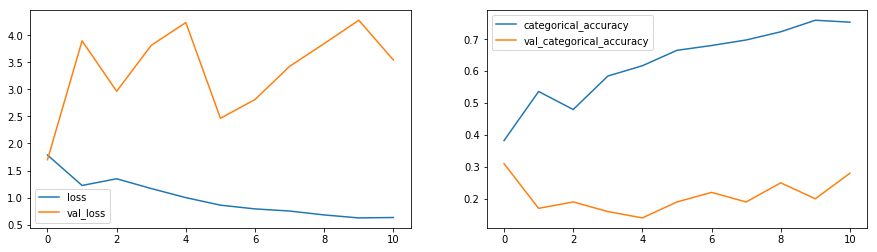

In [37]:
plot(history_model5)

### Conclusion
Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well

All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## CNN Model 5 
### Reducing the number of parameters

In [38]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_directory)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_50 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_50 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_35 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_51 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_51 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 8, 50, 50, 32)    

In [40]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8276 - categorical_accuracy: 0.3431
Epoch 00001: val_loss improved from inf to 1.92638, saving model to model_init_2021-03-0719_23_14.597768/model-00001-1.82763-0.34314-1.92638-0.21000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.8276 - categorical_accuracy: 0.3431 - val_loss: 1.9264 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2116 - categorical_accuracy: 0.5468
Epoch 00002: val_loss did not improve from 1.92638
34/34 [==============================] - 86s 3s/step - loss: 1.2116 - categorical_accuracy: 0.5468 - val_loss: 2.6272 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9985 - categorical_accuracy: 0.6290
Epoch 00003: val_loss did not improve from 1.92638
34/34 [==============================] - 86s 3s/step - loss: 0.9985

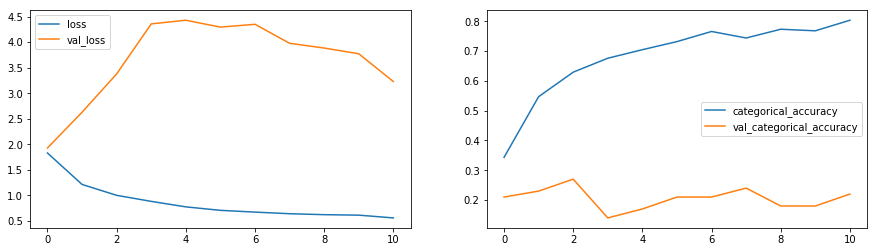

In [42]:
plot(history_model6)

### COnclusion
- We see that the model is overfitting again 

## Model 7 - Reducing the number of parameters again

In [44]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_directory)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 60, 60, 32)    

In [46]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7674 - categorical_accuracy: 0.3250
Epoch 00001: val_loss improved from inf to 1.70167, saving model to model_init_2021-03-0806_39_01.346682/model-00001-1.76737-0.32504-1.70167-0.17000.h5
34/34 [==============================] - 132s 4s/step - loss: 1.7674 - categorical_accuracy: 0.3250 - val_loss: 1.7017 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2633 - categorical_accuracy: 0.4955
Epoch 00002: val_loss did not improve from 1.70167
34/34 [==============================] - 95s 3s/step - loss: 1.2633 - categorical_accuracy: 0.4955 - val_loss: 2.0983 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0926 - categorical_accuracy: 0.5694
Epoch 00003: val_loss did not improve from 1.70167
34/34 [==============================] - 94s 3s/step - loss: 1.092

In [ ]:
plot(history_model7)

### Conclusion
As we can see, the accuracy did not improve much 

# Final Conclusion 
- We have tried out different variations around 8 using RNN and CNN
- We also used Transfer Learning mobile net, which gave us the best model 
- We also tried different variations of CNN3D , but we see the model is overfitting

# FINAL MODEL (Transfer Learning)

In [30]:
# Lets initialize params for image
test_t = gru_4(batch_s=5,image_s=120,epochs_n=20,sample_n=16)

Different technique of Normalization + cropping
# training sequences = 663
# validation sequences = 100
# epochs = 20


In [31]:
# Lets get the path of the model
final_model_path_t = "model_init_2021-03-0716_25_13.053674/model-00013-0.12388-0.95626-0.13724-0.96500.h5"
# Load the model
final_model_t = load_model(final_model_path)

In [32]:
test_generator_t = test.generator(test_t.val_path, test_t.val_doc)
test_data_t, test_label_t= next(test_generator_t)
# Lets check the shape of data that we fetched
test_data_t.shape

(10, 18, 120, 120, 3)

In [33]:
print("Actual Labels of gestures")
print(np.argmax(test_label_t,axis=1))

Actual Labels of gestures
[1 2 1 1 1 1 2 1 1 1]


In [34]:
print("Predicted Labels of gestures")
print(np.argmax(final_model_t.predict(test_data_t[:,:,:,:,:]),axis=1))

Predicted Labels of gestures
[1 2 1 1 1 1 2 1 0 1]


------------

# FINAL MODEL #1 (Optional)
- Lets load the model where we trained all weights in mobile net architecture with RNN

In [8]:
# Lets get the path of the model
final_model_path = "model_init_2021-03-0808_27_25.545230/model-00017-0.08410-0.97888-0.36941-0.86000.h5"
# Load the model
final_model = load_model(final_model_path)

In [9]:
# Lets initialize params for image
test = gru_3(batch_s=5,image_s=120,epochs_n=20,sample_n=18,dropout=0.25,dense_n=128,lstm_cells=128)
test_generator = test.generator(test.val_path, test.val_doc)

Different technique of Normalization + cropping
# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:
# Get the data
test_data, test_label= next(test_generator)

In [11]:
print("Actual Labels of gestures")
print(np.argmax(test_label,axis=1))

Actual Labels of gestures
[1 2 1 2 0 1 2 1 2 0]


In [12]:
print("Predicted Labels of gestures")
print(np.argmax(final_model.predict(test_data[:,:,:,:,:]),axis=1))

Predicted Labels of gestures
[0 2 1 2 0 0 0 1 2 0]
